# Image captioning deep learning model using ResNet50 encoder and hybrid LSTM–GRU decoder

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from PIL import Image
import string
import re
import json
from collections import Counter
import torch.nn as nn
import torchvision.models as models
import numpy as np
import time
import heapq
import torch.nn.functional as F

## Data set and Preprocessing

### 1: Select Flickr8k data set

In [3]:
base_path = "/content/drive/MyDrive/Colab Notebooks/HW4"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def show_images_with_captions(num_images_to_show: int, captions_file_path: str, images_dir_path: str):
    df_captions = pd.read_csv(captions_file_path)

    image_to_captions = {}
    for index, row in df_captions.iterrows():
        image_name = row['image']
        caption = row['caption']
        if image_name not in image_to_captions:
            image_to_captions[image_name] = []
        image_to_captions[image_name].append(caption.strip())

    if not image_to_captions:
        print(f"No captions found in {captions_file_path}")
        return

    unique_image_names = list(image_to_captions.keys())

    selected_image_names = random.sample(unique_image_names, num_images_to_show)

    for i, image_name in enumerate(selected_image_names):
        image_path = os.path.join(images_dir_path, image_name)
        img = Image.open(image_path)

        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(f"Image: {image_name} ({i+1}/{num_images_to_show})", fontsize=10)
        plt.axis('off')
        plt.show()

        captions_for_image = image_to_captions.get(image_name, [])
        if captions_for_image:
            for idx, cap in enumerate(captions_for_image):
                print(f"  {idx+1}. {cap}")
        else:
            print("No captions found.")
        print("-" * 50) # Separator


In [4]:
captions_file = os.path.join(base_path, "flickr8k/captions.txt")
images_folder = os.path.join(base_path, "flickr8k/Images")

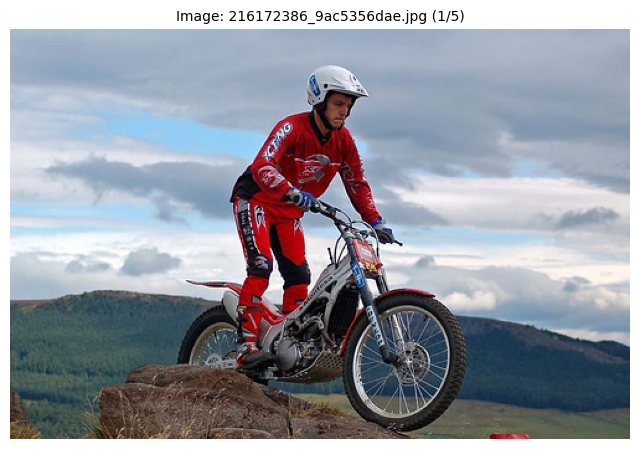

  1. A bike sits atop a rise with mountains in the background .
  2. A man wearing a red uniform and helmet stands on his motorbike .
  3. A motocross bike is being ridden over rocks .
  4. A motocross biker about to descend
  5. The motorcyclist has reached the summit .
--------------------------------------------------


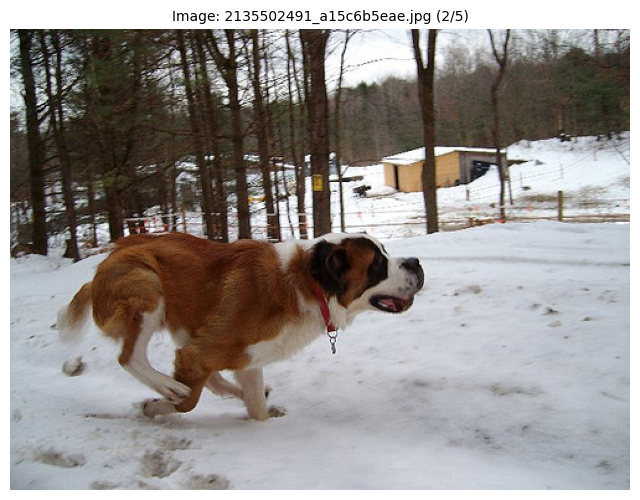

  1. A beautiful brown and white St Bernard running in the snow
  2. A St Bernard lunges through the snow .
  3. Large St Bernard dog wearing red collar galloping through the snow .
  4. St Bernard dog running in the snowy field .
  5. The large brown and white dog is running through the snow .
--------------------------------------------------


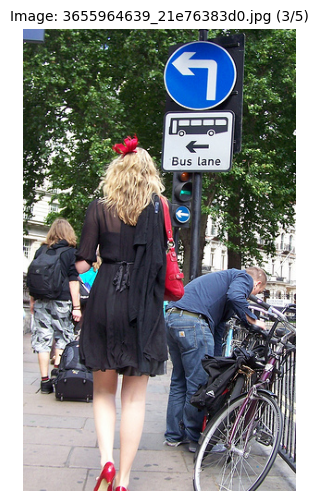

  1. A man chains his bike to a rack while a woman in black and red walks .
  2. Several people , one being a woman in a black dress , are outside , near a bike rack .
  3. The woman wearing a red bow walks past a bicycle .
  4. Woman in a black dress walking on the street .
  5. Woman in black dress with red accessories is walking down the street .
--------------------------------------------------


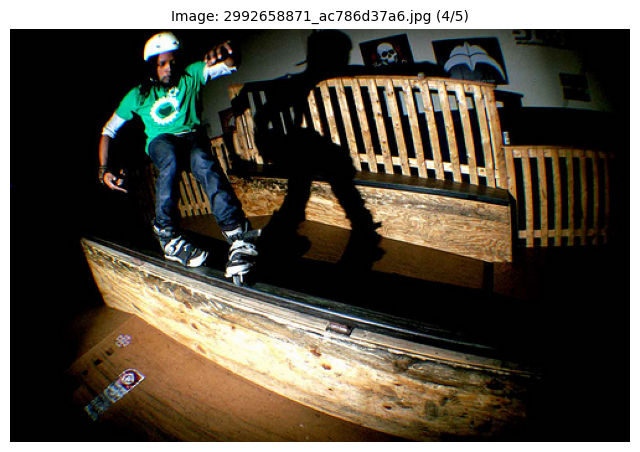

  1. A guy in green is rollerskating on a narrow strip .
  2. A man in a green shirt is skating on a railing .
  3. A man in a white helmet and green shirt grinds on his rollerblades .
  4. A man rollerblading on a metal bar .
  5. Rollerblades sliding on a railing .
--------------------------------------------------


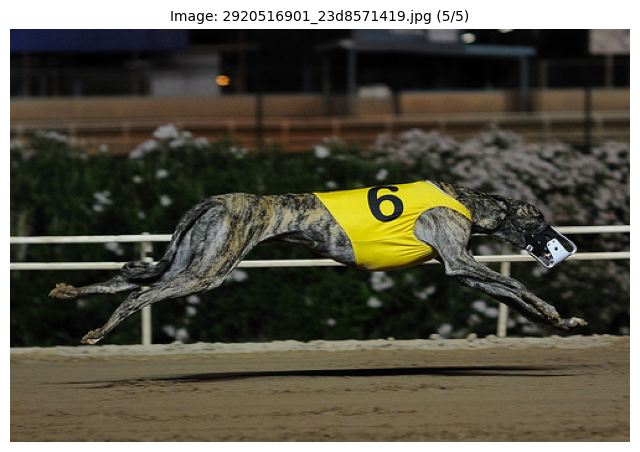

  1. A greyhound dog running in a race with identifier number six .
  2. A racing dog wearing a yellow jersey with number six .
  3. A running greyhound
  4. Gray , dappled dog with muzzle and yellow shirt marked 6 , runs on track .
  5. Greyhound dog in yellow jersey and running on a dirt track .
--------------------------------------------------


In [ ]:
show_images_with_captions(5, captions_file, images_folder)

### 2: Preprocessing images

In [5]:
img_size = 224
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

image_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

### 3: Preprocessing text (captions)

#### Create dictionary:

In [ ]:
def clean_caption(caption: str) -> str:

    text = caption.lower()

    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)

    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
def build_vocabulary(all_captions_list: list, min_word_freq: int = 1):

    all_tokens = []
    for caption in all_captions_list:
        tokens = caption.split(' ')
        all_tokens.extend(tokens)

    word_counts = Counter(all_tokens)

    words = [word for word, count in word_counts.items() if count >= min_word_freq and word]

    special_tokens = {
        '<pad>': 0,
        '<sos>': 1,
        '<eos>': 2,
        '<unk>': 3
    }

    word_to_idx = {}
    idx_to_word = {}

    for token, idx in special_tokens.items():
        word_to_idx[token] = idx
        idx_to_word[idx] = token

    next_idx = len(special_tokens)
    for word in words:
        if word not in word_to_idx:
            word_to_idx[word] = next_idx
            idx_to_word[next_idx] = word
            next_idx += 1

    print(f"Total unique words: {len(word_to_idx)}")
    return word_to_idx, idx_to_word

In [ ]:
def preprocess_captions_and_save_vocab(captions_file_path: str,
                                       vocab_json_path: str,
                                       min_word_freq: int = 1):

    df_captions = pd.read_csv(captions_file_path)
    if 'caption' not in df_captions.columns:
        print(f"Error: 'caption' column not found in {captions_file_path}.")
        if len(df_captions.columns) == 2:
             df_captions.columns = ['image', 'caption']
        else:
             print("Unexpected format")
             return

    cleaned_captions = []
    for i, caption_text in enumerate(df_captions['caption']):
        if pd.isna(caption_text):
            continue
        cleaned_captions.append(clean_caption(str(caption_text)))
    print(f"Finished cleaning {len(cleaned_captions)} captions.")

    # Dictionary
    word_to_idx, idx_to_word = build_vocabulary(cleaned_captions, min_word_freq)

    with open(vocab_json_path, 'w') as f:
        json.dump(word_to_idx, f, indent=4)
    print("Vocabulary saved.")

In [ ]:
captions_file = os.path.join(base_path, "flickr8k/captions.txt")
vocab_output_json = os.path.join(base_path, "flickr8k/vocab.json")

In [ ]:
min_frequency = 1
preprocess_captions_and_save_vocab(captions_file, vocab_output_json, min_frequency)

Finished cleaning 40455 captions.
Total unique words: 8782
Vocabulary saved.


#### Process captions and tokenize them:

In [ ]:
def numericalize_and_pad_caption(raw_caption: str,
                                 word_to_idx: dict,
                                 fixed_length: int) -> list[int]:
    if pd.isna(raw_caption):
        return [word_to_idx['<pad>']] * fixed_length

    cleaned = clean_caption(str(raw_caption))
    tokens = cleaned.split(' ')

    numerical_caption = [word_to_idx['<sos>']]

    for token in tokens:
        numerical_caption.append(word_to_idx.get(token, word_to_idx['<unk>']))

    numerical_caption.append(word_to_idx['<eos>'])

    current_len = len(numerical_caption)

    if current_len < fixed_length:
        padding = [word_to_idx['<pad>']] * (fixed_length - current_len)
        numerical_caption.extend(padding)

    elif current_len > fixed_length:
        processed_caption_part = numerical_caption[1:-1]
        max_content_tokens = fixed_length - 2
        if max_content_tokens < 0: max_content_tokens = 0
        truncated_content = processed_caption_part[:max_content_tokens]
        numerical_caption = [word_to_idx['<sos>']] + truncated_content + [word_to_idx['<eos>']]

        current_len_after_trunc_logic = len(numerical_caption)
        if current_len_after_trunc_logic < fixed_length:
            padding = [word_to_idx['<pad>']] * (fixed_length - current_len_after_trunc_logic)
            numerical_caption.extend(padding)
        numerical_caption = numerical_caption[:fixed_length]

    return numerical_caption

In [ ]:
def process_all_captions(captions_file_path: str,
                         word_to_idx: dict,
                         fixed_caption_length: int,
                         output_json_path: str):
    try:
        df_captions = pd.read_csv(captions_file_path)
        if 'image' not in df_captions.columns or 'caption' not in df_captions.columns:
            if len(df_captions.columns) == 2:
                 df_captions.columns = ['image', 'caption']
            else:
                print("Unexpected format")
                return

        processed_data = {}

        for index, row in df_captions.iterrows():
            image_name = row['image']
            raw_caption = row['caption']

            numerical_caption = numericalize_and_pad_caption(raw_caption, word_to_idx, fixed_caption_length)

            if image_name not in processed_data:
                processed_data[image_name] = []
            processed_data[image_name].append(numerical_caption)


        os.makedirs(os.path.dirname(output_json_path), exist_ok=True)
        with open(output_json_path, 'w') as f:
            json.dump(processed_data, f, indent=2)
        print("Processed captions saved.")

        return processed_data

    except FileNotFoundError:
        print(f"Error: Captions file not found at {captions_file_path}.")
    except Exception as e:
        print(f"An unexpected error occurred during caption processing: {e}")
        raise


In [ ]:
CAPTION_LENGTH = 20
processed_captions_output_file = os.path.join(base_path, "flickr8k/processed_captions.json")

word_to_idx_dictionary = None
if os.path.exists(vocab_output_json):
    with open(vocab_output_json, 'r') as f:
        word_to_idx_dictionary = json.load(f)
    print(f"Vocabulary loaded. Size: {len(word_to_idx_dictionary)}")
else:
    print(f"Vocabulary file not found at {vocab_output_json}..")

processed_captions_data = process_all_captions(captions_file, word_to_idx_dictionary,
                                              CAPTION_LENGTH, processed_captions_output_file)



Vocabulary loaded. Size: 8782
Processed captions saved.


In [ ]:
num_examples_to_show = 2
count = 0
for image_name, num_caps_list in processed_captions_data.items():
    if count >= num_examples_to_show:
        break
    print(f"\nImage: {image_name}")
    for i, num_cap in enumerate(num_caps_list[:3]):
        print(f"  Caption {i+1} (IDs): {num_cap}")
        print(f"    Length: {len(num_cap)}")
        idx_to_word_map = {idx: word for word, idx in word_to_idx_dictionary.items()}
        words_repr = [idx_to_word_map.get(idx, '?') for idx in num_cap]
        print(f"    As words: {' '.join(words_repr)}")
    count += 1


Image: 1000268201_693b08cb0e.jpg
  Caption 1 (IDs): [1, 4, 5, 6, 4, 7, 8, 9, 10, 11, 4, 12, 13, 14, 6, 15, 16, 17, 2, 0]
    Length: 20
    As words: <sos> a child in a pink dress is climbing up a set of stairs in an entry way <eos> <pad>
  Caption 2 (IDs): [1, 4, 18, 19, 20, 4, 21, 22, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    Length: 20
    As words: <sos> a girl going into a wooden building <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
  Caption 3 (IDs): [1, 4, 23, 18, 10, 20, 4, 21, 24, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    Length: 20
    As words: <sos> a little girl climbing into a wooden playhouse <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

Image: 1001773457_577c3a7d70.jpg
  Caption 1 (IDs): [1, 4, 29, 30, 31, 4, 32, 30, 33, 34, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    Length: 20
    As words: <sos> a black dog and a spotted dog are fighting <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
  Caption 2 (IDs): [1, 4, 29, 30, 31, 4

### 4: Dividing data set

In [ ]:
def split_image_caption_data(processed_captions_path: str,
                             output_dir: str,
                             train_ratio: float = 0.8,
                             val_ratio: float = 0.1,
                             random_seed: int = 42):

    test_ratio = 1.0 - train_ratio - val_ratio

    with open(processed_captions_path, 'r') as f:
        processed_data = json.load(f)

    if not processed_data:
        print("Error: No data found in the processed captions file.")
        return

    image_filenames = list(processed_data.keys())
    num_total_images = len(image_filenames)

    random.seed(random_seed)
    random.shuffle(image_filenames)

    num_train = int(train_ratio * num_total_images)
    num_val = int(val_ratio * num_total_images)

    train_files = image_filenames[:num_train]
    val_files = image_filenames[num_train : num_train + num_val]
    test_files = image_filenames[num_train + num_val :]

    print(f"Number of images for training: {len(train_files)}")
    print(f"Number of images for validation: {len(val_files)}")
    print(f"Number of images for testing: {len(test_files)}")

    train_data_split = {img_file: processed_data[img_file] for img_file in train_files}
    val_data_split = {img_file: processed_data[img_file] for img_file in val_files}
    test_data_split = {img_file: processed_data[img_file] for img_file in test_files}

    os.makedirs(output_dir, exist_ok=True)

    split_filenames = {
        "train": "train_data.json",
        "validation": "val_data.json",
        "test": "test_data.json"
    }

    data_to_save = {
        "train": train_data_split,
        "validation": val_data_split,
        "test": test_data_split
    }

    for split_name, data in data_to_save.items():
        output_path = os.path.join(output_dir, split_filenames[split_name])
        with open(output_path, 'w') as f:
            json.dump(data, f, indent=2)


In [ ]:
input_processed_captions_file = os.path.join(base_path, "flickr8k/processed_captions.json")

output_directory_for_splits = os.path.join(base_path, "flickr8k/")


split_image_caption_data(
    processed_captions_path=input_processed_captions_file,
    output_dir=output_directory_for_splits,
    train_ratio=0.8,
    val_ratio=0.1,
    random_seed=42
)



Number of images for training: 6472
Number of images for validation: 809
Number of images for testing: 810


## Model implementation

### 1: CNN Encoder

In [6]:
class ResNet50Encoder(nn.Module):
    def __init__(self):

        super(ResNet50Encoder, self).__init__()
        resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        modules = list(resnet50.children())[:-1]
        self.resnet_features = nn.Sequential(*modules)

        for param in self.resnet_features.parameters():
            param.requires_grad_(False)

    def forward(self, images: torch.Tensor) -> torch.Tensor:

        features = self.resnet_features(images)
        features = torch.flatten(features, start_dim=1)

        return features

In [ ]:
encoder = ResNet50Encoder()
encoder.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 188MB/s]


ResNet50Encoder(
  (resnet_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [ ]:
dummy_pil_image = Image.new('RGB', (300, 300), color='blue')
dummy_input_tensor = image_transform(dummy_pil_image).unsqueeze(0)
print(f"\nShape of input tensor: {dummy_input_tensor.shape}")

with torch.no_grad():
    feature_vector = encoder(dummy_input_tensor)

print(f"Shape of output feature vector: {feature_vector.shape}")


Shape of input tensor: torch.Size([1, 3, 224, 224])
Shape of output feature vector: torch.Size([1, 2048])


### 2: Decoder

In [7]:
class HybridLSTMGRUDecoder(nn.Module):
    def __init__(self, embed_size: int, hidden_size: int, vocab_size: int,
                 encoder_feature_dim: int = 2048, dropout_rate: float = 0.5):
        super(HybridLSTMGRUDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.init_h_lstm = nn.Linear(encoder_feature_dim, hidden_size)
        self.init_c_lstm = nn.Linear(encoder_feature_dim, hidden_size)
        self.lstm_cell = nn.LSTMCell(embed_size, hidden_size)
        self.gru_cell = nn.GRUCell(hidden_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc_out = nn.Linear(hidden_size, vocab_size)

    def init_lstm_states(self, encoder_features: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        h_lstm = torch.tanh(self.init_h_lstm(encoder_features))
        c_lstm = torch.tanh(self.init_c_lstm(encoder_features))
        return h_lstm, c_lstm

    def init_gru_hidden_state(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.hidden_size, device=device)

    def forward_step(self, current_word_embedded: torch.Tensor,
                     h_lstm: torch.Tensor, c_lstm: torch.Tensor,
                     h_gru: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

        h_lstm_next, c_lstm_next = self.lstm_cell(current_word_embedded, (h_lstm, c_lstm))
        h_gru_next = self.gru_cell(c_lstm_next, h_gru)
        dropped_h_gru = self.dropout(h_gru_next)
        output_logits = self.fc_out(dropped_h_gru)
        return output_logits, h_lstm_next, c_lstm_next, h_gru_next

    def forward(self, encoder_features: torch.Tensor, captions_in: torch.Tensor):
        batch_size = encoder_features.size(0)
        seq_len = captions_in.size(1)
        device = encoder_features.device
        h_lstm, c_lstm = self.init_lstm_states(encoder_features)
        h_gru = self.init_gru_hidden_state(batch_size, device)
        embeddings = self.embedding(captions_in)
        outputs = torch.zeros(batch_size, seq_len, self.fc_out.out_features, device=device)
        for t in range(seq_len):
            current_embedding = embeddings[:, t, :]
            output_logits, h_lstm, c_lstm, h_gru = self.forward_step(current_embedding, h_lstm, c_lstm, h_gru)
            outputs[:, t, :] = output_logits
        return outputs

### 3: End-to-End Model

In [35]:
class HybridCaptioningModel(nn.Module):
    def __init__(self, embed_size: int, hidden_size: int, vocab_size: int,
                 encoder_feature_dim: int = 2048, dropout_rate: float = 0.5,
                 freeze_encoder: bool = True):
        super(HybridCaptioningModel, self).__init__()
        self.encoder = ResNet50Encoder()
        if not freeze_encoder:
            for param in self.encoder.parameters(): param.requires_grad_(True)
        else:
            for param in self.encoder.parameters(): param.requires_grad_(False)

        self.decoder = HybridLSTMGRUDecoder(
            embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size,
            encoder_feature_dim=encoder_feature_dim, dropout_rate=dropout_rate
        )
        self.vocab_size = vocab_size

    def forward(self, images: torch.Tensor, captions_in: torch.Tensor) -> torch.Tensor:
        image_features = self.encoder(images)
        return self.decoder(image_features, captions_in)

    def generate_caption_greedy(self, image: torch.Tensor, vocab, max_len: int = 20, device=DEVICE) -> list[int]:
        self.eval()
        if image.dim() == 3: image = image.unsqueeze(0)
        image = image.to(device)

        with torch.no_grad():
            encoder_features = self.encoder(image)
            batch_size = encoder_features.size(0)

            h_lstm, c_lstm = self.decoder.init_lstm_states(encoder_features)
            h_gru = self.decoder.init_gru_hidden_state(batch_size, device)

            sampled_ids = []
            current_word_id = torch.tensor([vocab['<sos>']], device=device)

            for _ in range(max_len):
                current_embedding = self.decoder.embedding(current_word_id)
                output_logits, h_lstm, c_lstm, h_gru = self.decoder.forward_step(
                    current_embedding, h_lstm, c_lstm, h_gru
                )
                predicted_id = output_logits.argmax(1)
                sampled_ids.append(predicted_id.item())
                if predicted_id.item() == vocab['<eos>']: break
                current_word_id = predicted_id
        return sampled_ids

    def generate_caption_beam_search(self, image_tensor: torch.Tensor, vocab,
                                     max_len: int = 20, beam_width: int = 5,
                                     top_n_expansions_per_beam: int = -1,
                                     device=DEVICE) -> list[int]:
        self.eval()
        if image_tensor.dim() == 3: image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to(device)

        if top_n_expansions_per_beam <= 0 or top_n_expansions_per_beam >= self.vocab_size:
            actual_top_n_expansions = self.vocab_size
        else:
            actual_top_n_expansions = top_n_expansions_per_beam

        if top_n_expansions_per_beam == -1 :
             actual_top_n_expansions = 1000


        with torch.no_grad():
            encoder_features = self.encoder(image_tensor)
            h_lstm_orig, c_lstm_orig = self.decoder.init_lstm_states(encoder_features)
            h_gru_orig = self.decoder.init_gru_hidden_state(1, device)

            start_token_id = vocab['<sos>']
            end_token_id = vocab['<eos>']

            beams = [(0.0, [start_token_id], h_lstm_orig, c_lstm_orig, h_gru_orig)]
            completed_sequences = []

            for _step in range(max_len):
                if not beams:
                    break

                all_next_step_candidates = []

                for score, seq_ids, h_lstm, c_lstm, h_gru in beams:
                    if seq_ids[-1] == end_token_id:
                        length_penalty_factor = len(seq_ids) ** 0.7
                        completed_sequences.append((score / length_penalty_factor, seq_ids))
                        continue

                    last_word_id = torch.tensor([seq_ids[-1]], device=device)
                    current_embedding = self.decoder.embedding(last_word_id)

                    output_logits, h_lstm_next, c_lstm_next, h_gru_next = self.decoder.forward_step(
                        current_embedding, h_lstm, c_lstm, h_gru
                    )
                    log_probs = F.log_softmax(output_logits.squeeze(0), dim=0)

                    top_log_probs, top_indices = torch.topk(log_probs, actual_top_n_expansions)

                    for k_idx in range(actual_top_n_expansions):
                        word_id = top_indices[k_idx].item()
                        log_prob_word = top_log_probs[k_idx].item()

                        new_seq_ids = seq_ids + [word_id]
                        new_score = score + log_prob_word
                        all_next_step_candidates.append({
                            'score': new_score, 'seq': new_seq_ids,
                            'h_lstm': h_lstm_next.clone(),
                            'c_lstm': c_lstm_next.clone(),
                            'h_gru': h_gru_next.clone()
                        })

                if not all_next_step_candidates and not completed_sequences : break
                if not all_next_step_candidates and completed_sequences : break

                ordered_candidates = sorted(all_next_step_candidates, key=lambda x: x['score'], reverse=True)

                beams = []
                for cand_dict in ordered_candidates:
                    if len(beams) >= beam_width:
                        break
                    beams.append((cand_dict['score'], cand_dict['seq'],
                                  cand_dict['h_lstm'], cand_dict['c_lstm'], cand_dict['h_gru']))

                temp_active_beams = []
                all_current_beams_ended_this_step = True
                for b_score, b_seq, b_hl, b_cl, b_hg in beams:
                    if b_seq[-1] == end_token_id:
                        length_penalty_factor = len(b_seq) ** 0.7
                        completed_sequences.append((b_score / length_penalty_factor, b_seq))
                    else:
                        temp_active_beams.append((b_score, b_seq, b_hl, b_cl, b_hg))
                        all_current_beams_ended_this_step = False
                beams = temp_active_beams

                if len(completed_sequences) >= beam_width and all_current_beams_ended_this_step:
                    break

            for score, seq_ids, _, _, _ in beams:
                length_penalty_factor = len(seq_ids) ** 0.7
                completed_sequences.append((score/length_penalty_factor, seq_ids))

            if not completed_sequences:
                if beams:
                    beams.sort(key=lambda x: x[0] / (len(x[1])**0.7), reverse=True)
                    return beams[0][1]
                return [start_token_id, end_token_id]

            completed_sequences.sort(key=lambda x: x[0], reverse=True)
            best_seq_ids = completed_sequences[0][1]

            return best_seq_ids


## Training model and evaluation

### 1: Training

#### Load data set

In [9]:
class Flickr8kDataset(Dataset):

    def __init__(self, json_file_path: str, images_dir_path: str,
                 vocab,
                 transform=None, fixed_caption_length=None):

        super().__init__()
        with open(json_file_path, 'r') as f:
            self.data = json.load(f)

        self.images_dir_path = images_dir_path
        self.transform = transform
        self.vocab = vocab

        self.samples = []
        for img_filename, captions_list in self.data.items():
            for numerical_caption in captions_list:
                self.samples.append((img_filename, numerical_caption))

        if not self.samples:
            raise ValueError(f"No samples found.")

        if fixed_caption_length is None:
            self.fixed_caption_length = len(self.samples[0][1])
        else:
            self.fixed_caption_length = fixed_caption_length

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        img_filename, numerical_caption = self.samples[idx]

        image_path = os.path.join(self.images_dir_path, img_filename)
        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError:
            print(f"Image file not found at {image_path}.")
        except Exception as e:
            print(f"Could not load image {image_path}.")
            raise

        if self.transform:
            image = self.transform(image)

        caption_tensor = torch.tensor(numerical_caption, dtype=torch.long)

        caption_input = caption_tensor[:-1]
        caption_target = caption_tensor[1:]

        return image, caption_input, caption_target

In [10]:
IMAGES_DIR = os.path.join(base_path, "flickr8k/Images")
VOCAB_FILE = os.path.join(base_path, "flickr8k/vocab.json")
TRAIN_JSON = os.path.join(base_path, "flickr8k/train_data.json")
VAL_JSON = os.path.join(base_path, "flickr8k/val_data.json")
TEST_JSON = os.path.join(base_path, "flickr8k/test_data.json")

essential_paths = {
    "Images Directory": IMAGES_DIR,
    "Vocabulary File": VOCAB_FILE,
    "Train JSON": TRAIN_JSON,
    "Validation JSON": VAL_JSON,
    "Test JSON": TEST_JSON
}
for name, path in essential_paths.items():
    if not os.path.exists(path):
        print("Files were not found!")
        exit()

with open(VOCAB_FILE, 'r') as f:
    vocab = json.load(f)

BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataset = Flickr8kDataset(
    json_file_path=TRAIN_JSON,
    images_dir_path=IMAGES_DIR,
    vocab=vocab,
    transform=image_transform
)

val_dataset = Flickr8kDataset(
    json_file_path=VAL_JSON,
    images_dir_path=IMAGES_DIR,
    vocab=vocab,
    transform=image_transform
)

test_dataset = Flickr8kDataset(
    json_file_path=TEST_JSON,
    images_dir_path=IMAGES_DIR,
    vocab=vocab,
    transform=image_transform
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)


#### Train model

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs,
                vocab_size, device, model_save_path):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    print(f"\nStarting training for {num_epochs} epochs on {device}...")

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        running_train_loss = 0.0

        for batch_idx, (images, caption_inputs, caption_targets) in enumerate(train_loader):
            images = images.to(device)
            caption_inputs = caption_inputs.to(device)
            caption_targets = caption_targets.to(device)

            optimizer.zero_grad()

            predictions = model(images, caption_inputs)

            loss = criterion(predictions.reshape(-1, vocab_size), caption_targets.reshape(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f"  Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, caption_inputs, caption_targets in val_loader:
                images = images.to(device)
                caption_inputs = caption_inputs.to(device)
                caption_targets = caption_targets.to(device)

                predictions = model(images, caption_inputs)
                loss = criterion(predictions.reshape(-1, vocab_size), caption_targets.reshape(-1))
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f}s:")
        print(f"  Avg Training Loss: {avg_train_loss:.4f}, Avg Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"  Best model saved to {model_save_path} (Val Loss: {best_val_loss:.4f})")

    print("Training complete.")
    return train_losses, val_losses


In [ ]:
EMBED_SIZE = 256
HIDDEN_SIZE = 512
ENCODER_DIM = 2048
DROPOUT_RATE = 0.5
FREEZE_ENCODER = True
with open(VOCAB_FILE, 'r') as f:
        vocab = json.load(f)

VOCAB_SIZE = len(vocab)

# Instantiate model
caption_model = HybridCaptioningModel(
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    vocab_size=VOCAB_SIZE,
    encoder_feature_dim=ENCODER_DIM,
    dropout_rate=DROPOUT_RATE,
    freeze_encoder=FREEZE_ENCODER
).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


In [ ]:
PAD_TOKEN_ID = vocab.get('<pad>', 0)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN_ID)

if FREEZE_ENCODER:
    optimizer = optim.Adam(caption_model.decoder.parameters(), lr=0.001)
else:
    optimizer = optim.Adam(caption_model.parameters(), lr=0.001)

NUM_EPOCHS = 40

In [ ]:
MODEL_SAVE_PATH = os.path.join(base_path, "best_hybrid_caption_model.pth")

train_history, val_history = train_model(
        model=caption_model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        vocab_size=VOCAB_SIZE,
        device=DEVICE,
        model_save_path=MODEL_SAVE_PATH
    )


Starting training for 40 epochs on cuda...
  Epoch [1/40], Batch [100/1012], Train Loss: 4.5747
  Epoch [1/40], Batch [200/1012], Train Loss: 4.1514
  Epoch [1/40], Batch [300/1012], Train Loss: 4.1426
  Epoch [1/40], Batch [400/1012], Train Loss: 3.8342
  Epoch [1/40], Batch [500/1012], Train Loss: 3.8562
  Epoch [1/40], Batch [600/1012], Train Loss: 3.3232
  Epoch [1/40], Batch [700/1012], Train Loss: 3.8686
  Epoch [1/40], Batch [800/1012], Train Loss: 3.4306
  Epoch [1/40], Batch [900/1012], Train Loss: 3.3640
  Epoch [1/40], Batch [1000/1012], Train Loss: 3.2004
Epoch [1/40] completed in 3079.94s:
  Avg Training Loss: 3.9101, Avg Validation Loss: 3.3187
  Best model saved to /content/drive/My Drive/Colab Notebooks/HW4/best_hybrid_caption_model.pth (Val Loss: 3.3187)
  Epoch [2/40], Batch [100/1012], Train Loss: 3.1879
  Epoch [2/40], Batch [200/1012], Train Loss: 3.2018
  Epoch [2/40], Batch [300/1012], Train Loss: 3.2892
  Epoch [2/40], Batch [400/1012], Train Loss: 3.2124
  Epo

### 2: Evaluation

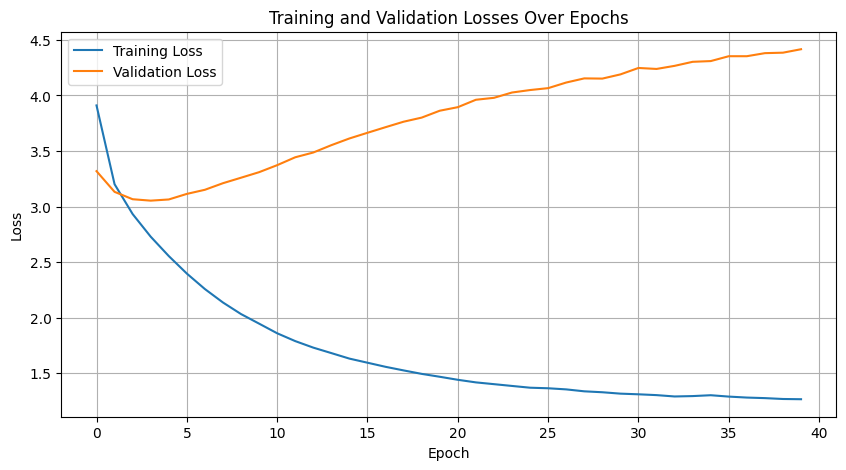

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save final model
final_model_save_path = os.path.join(base_path, "final_hybrid_caption_model.pth")
torch.save(caption_model.state_dict(), final_model_save_path)


In [ ]:
MODEL_SAVE_PATH = os.path.join(base_path, "best_hybrid_caption_model.pth")
final_model_save_path = os.path.join(base_path, "final_hybrid_caption_model.pth")

In [ ]:
model = HybridCaptioningModel(
    embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE,
    encoder_feature_dim=ENCODER_DIM, dropout_rate=DROPOUT_RATE
).to(DEVICE)

#model.load_state_dict(torch.load(final_model_save_path, map_location=DEVICE))
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
model.eval()

HybridCaptioningModel(
  (encoder): ResNet50Encoder(
    (resnet_features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu):

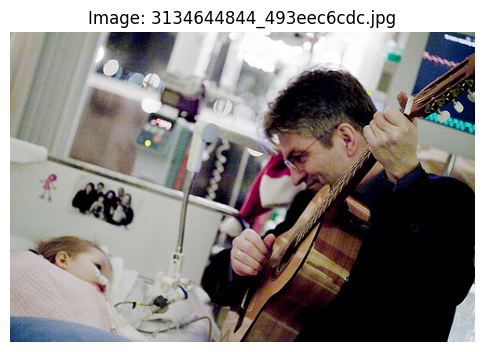

Image: 3134644844_493eec6cdc.jpg
  Reference Caption: a man is playing a guitar for a little girl in a hospital
  Greedy Search:     a man in a blue shirt is holding a cup
  Beam Search (k=5): a young boy in a blue shirt is playing with a ball
--------------------------------------------------


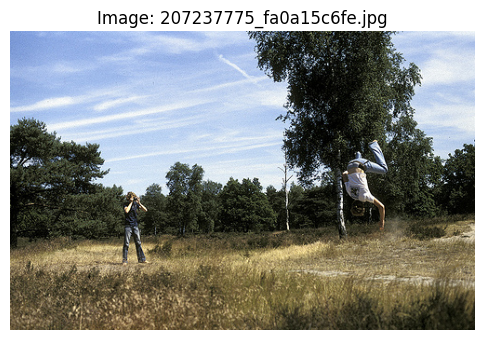

Image: 207237775_fa0a15c6fe.jpg
  Reference Caption: a man doing a back flip while another takes a picture
  Greedy Search:     a man in a blue shirt is standing in front of a large rock
  Beam Search (k=5): a man in a blue shirt is standing in front of a crowd
--------------------------------------------------


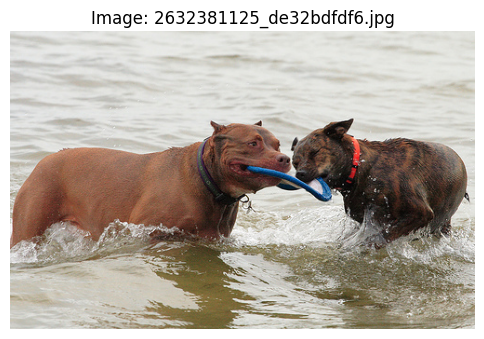

Image: 2632381125_de32bdfdf6.jpg
  Reference Caption: two brown dogs play with a frisbee in the water
  Greedy Search:     a brown dog is running through a field of grass
  Beam Search (k=5): a brown and white dog is running through the grass
--------------------------------------------------


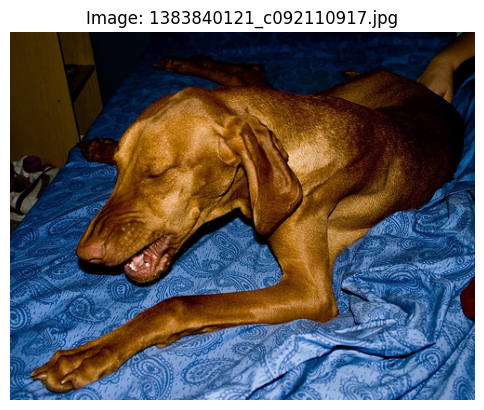

Image: 1383840121_c092110917.jpg
  Reference Caption: a brown dog laying on a blue cover
  Greedy Search:     a brown dog is running through a field of grass
  Beam Search (k=5): a brown dog is standing on its hind legs
--------------------------------------------------


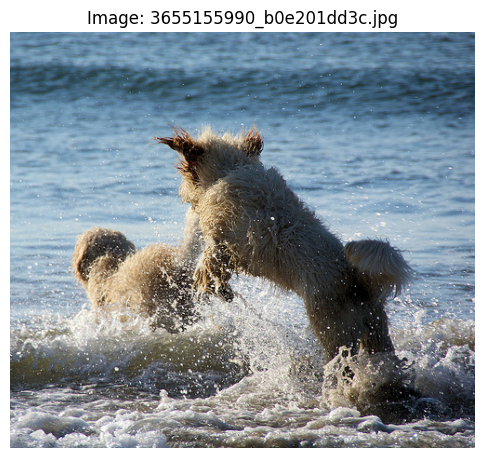

Image: 3655155990_b0e201dd3c.jpg
  Reference Caption: two dogs playing in the water
  Greedy Search:     a brown dog is running through a field of tall grass
  Beam Search (k=5): a black and white dog is running through the grass
--------------------------------------------------


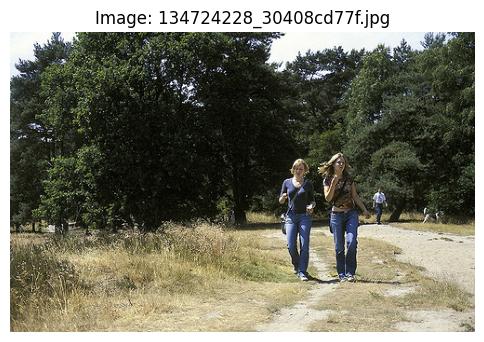

Image: 134724228_30408cd77f.jpg
  Reference Caption: two girls are walking down a dirt road in a park
  Greedy Search:     a man in a blue shirt is standing in front of a large rock
  Beam Search (k=5): a group of people are standing on a grassy hill
--------------------------------------------------


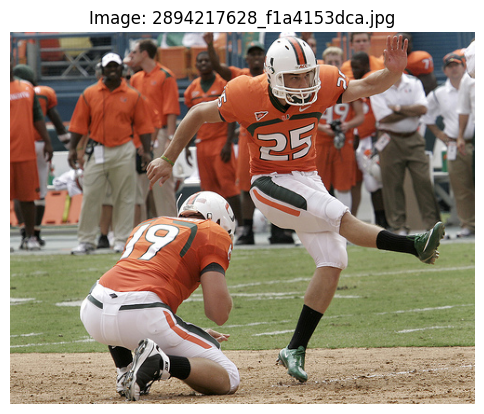

Image: 2894217628_f1a4153dca.jpg
  Reference Caption: a holder and kicker for a football team dressed in orange white and black play while onlookers behind
  Greedy Search:     a group of people are standing on a sidewalk
  Beam Search (k=5): a group of people are standing in a field
--------------------------------------------------


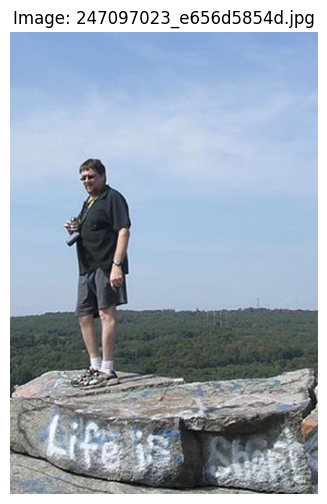

Image: 247097023_e656d5854d.jpg
  Reference Caption: a man in a dark shirt and shorts is standing on top of a high graffitied rock
  Greedy Search:     a man in a blue shirt is standing next to a woman in a black jacket
  Beam Search (k=5): a man in a blue shirt is looking at the camera
--------------------------------------------------


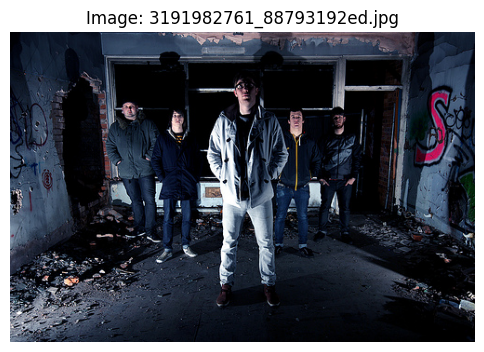

Image: 3191982761_88793192ed.jpg
  Reference Caption: a group of five men are standing in the middle of a room that is crumbling and abandoned
  Greedy Search:     a man in a blue shirt is standing next to a woman in a black jacket
  Beam Search (k=5): a group of people are standing in front of a brick building
--------------------------------------------------


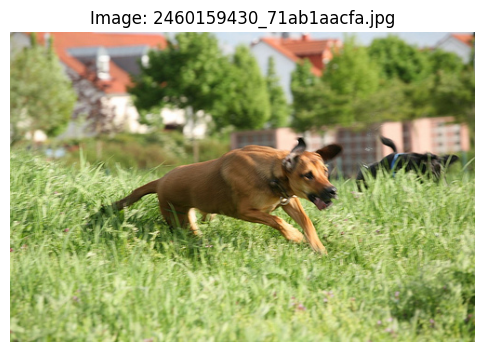

Image: 2460159430_71ab1aacfa.jpg
  Reference Caption: a brown dog races through a field
  Greedy Search:     a brown dog is running through a field
  Beam Search (k=5): two dogs are playing in the grass
--------------------------------------------------


In [ ]:
num_images_to_display = 10
idx_to_word = {idx: word for word, idx_str in vocab.items() for idx in [int(idx_str)]}
unique_test_image_files = list(test_dataset.data.keys())

selected_image_filenames = random.sample(unique_test_image_files, num_images_to_display)


for img_filename in selected_image_filenames:
    image_path = os.path.join(IMAGES_DIR, img_filename)
    pil_image = Image.open(image_path).convert("RGB")
    transformed_image = image_transform(pil_image)

    greedy_ids = model.generate_caption_greedy(transformed_image, vocab, max_len=20, device=DEVICE)
    greedy_caption = ' '.join([idx_to_word.get(idx, '<unk>') for idx in greedy_ids if idx != vocab['<sos>'] and idx != vocab['<pad>']])
    if greedy_caption.endswith(" <eos>"): greedy_caption = greedy_caption[:-len(" <eos>")]

    beam_width = 5
    beam_ids = model.generate_caption_beam_search(transformed_image, vocab, max_len=20, beam_width=beam_width, device=DEVICE)
    beam_caption = ' '.join([idx_to_word.get(idx, '<unk>') for idx in beam_ids if idx != vocab['<sos>'] and idx != vocab['<pad>']])
    if beam_caption.endswith(" <eos>"): beam_caption = beam_caption[:-len(" <eos>")]

    plt.figure(figsize=(6,6))
    plt.imshow(pil_image)
    plt.title(f"Image: {img_filename}")
    plt.axis('off')
    plt.show()

    print(f"Image: {img_filename}")
    reference_captions_ids = test_dataset.data[img_filename]
    if reference_captions_ids:
        ref_ids = reference_captions_ids[0]
        ref_caption_words = [idx_to_word.get(r_id, "<unk>") for r_id in ref_ids if r_id != vocab['<sos>'] and r_id != vocab['<pad>']]
        if ref_caption_words and ref_caption_words[-1] == "<eos>": ref_caption_words = ref_caption_words[:-1]
        print(f"  Reference Caption: {' '.join(ref_caption_words)}")

    print(f"  Greedy Search:     {greedy_caption}")
    print(f"  Beam Search (k={beam_width}): {beam_caption}")
    print("-" * 50)

## Bonus

In [12]:
import nltk
try:
    from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
except ImportError:
    nltk.download('punkt')
    from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

In [13]:
def ids_to_clean_words(ids_list, idx_to_word_map, vocab_map):
    words = []
    for token_id in ids_list:
        if token_id == vocab_map['<sos>']: continue
        if token_id == vocab_map['<eos>']: break
        if token_id == vocab_map['<pad>']: continue
        words.append(idx_to_word_map.get(token_id, '<unk>'))
    return words

In [ ]:
with open(TEST_JSON, 'r') as f:
    test_data_json = json.load(f)
test_image_filenames = list(test_data_json.keys())

with open(VOCAB_FILE, 'r') as f:
    vocab_map = json.load(f)
idx_to_word_map = {int(idx_str): word for word, idx_str in vocab_map.items()}

greedy_hypotheses = []
beam_hypotheses = []
all_references = []

BEAM_WIDTH = 5
MAX_CAPTION_LEN = 20


for i, img_filename in enumerate(test_image_filenames):
    image_path = os.path.join(IMAGES_DIR, img_filename)
    try:
        pil_image = Image.open(image_path).convert("RGB")
        transformed_image = image_transform(pil_image)
    except FileNotFoundError:
        print(f"Image {img_filename} not found at {image_path}.")
        continue

    reference_ids_list = test_data_json[img_filename]
    current_image_references = [ids_to_clean_words(ref_ids, idx_to_word_map, vocab_map) for ref_ids in reference_ids_list]
    all_references.append(current_image_references)

    greedy_ids = model.generate_caption_greedy(transformed_image, vocab_map, max_len=MAX_CAPTION_LEN, device=DEVICE)
    greedy_words = ids_to_clean_words(greedy_ids, idx_to_word_map, vocab_map)
    greedy_hypotheses.append(greedy_words)

    beam_ids = model.generate_caption_beam_search(transformed_image, vocab_map, max_len=MAX_CAPTION_LEN, beam_width=BEAM_WIDTH, device=DEVICE)
    beam_words = ids_to_clean_words(beam_ids, idx_to_word_map, vocab_map)
    beam_hypotheses.append(beam_words)

    if (i + 1) % 50 == 0:
        print(f"  Processed {i+1}/{len(test_image_filenames)} images...")

chencherry = SmoothingFunction()

if greedy_hypotheses:
    bleu1_greedy = corpus_bleu(all_references, greedy_hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=chencherry.method1)
    bleu2_greedy = corpus_bleu(all_references, greedy_hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method1)
    bleu3_greedy = corpus_bleu(all_references, greedy_hypotheses, weights=(0.333, 0.333, 0.333, 0), smoothing_function=chencherry.method1)
    bleu4_greedy = corpus_bleu(all_references, greedy_hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)
    print("\n--- Greedy Search BLEU Scores ---")
    print(f"  BLEU-1: {bleu1_greedy:.4f}")
    print(f"  BLEU-2: {bleu2_greedy:.4f}")
    print(f"  BLEU-3: {bleu3_greedy:.4f}")
    print(f"  BLEU-4: {bleu4_greedy:.4f}")

if beam_hypotheses:
    bleu1_beam = corpus_bleu(all_references, beam_hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=chencherry.method1)
    bleu2_beam = corpus_bleu(all_references, beam_hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method1)
    bleu3_beam = corpus_bleu(all_references, beam_hypotheses, weights=(0.333, 0.333, 0.333, 0), smoothing_function=chencherry.method1)
    bleu4_beam = corpus_bleu(all_references, beam_hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)
    print(f"\n--- Beam Search (k={BEAM_WIDTH}) BLEU Scores ---")
    print(f"  BLEU-1: {bleu1_beam:.4f}")
    print(f"  BLEU-2: {bleu2_beam:.4f}")
    print(f"  BLEU-3: {bleu3_beam:.4f}")
    print(f"  BLEU-4: {bleu4_beam:.4f}")


  Processed 50/810 images...
  Processed 100/810 images...
  Processed 150/810 images...
  Processed 200/810 images...
  Processed 250/810 images...
  Processed 300/810 images...
  Processed 350/810 images...
  Processed 400/810 images...
  Processed 450/810 images...
  Processed 500/810 images...
  Processed 550/810 images...
  Processed 600/810 images...
  Processed 650/810 images...
  Processed 700/810 images...
  Processed 750/810 images...
  Processed 800/810 images...

--- Greedy Search BLEU Scores ---
  BLEU-1: 0.4541
  BLEU-2: 0.2802
  BLEU-3: 0.1747
  BLEU-4: 0.1118

--- Beam Search (k=5) BLEU Scores ---
  BLEU-1: 0.4810
  BLEU-2: 0.2954
  BLEU-3: 0.1875
  BLEU-4: 0.1217


## Modified Model

In [14]:
def train_model_v2(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs, vocab_size, device, model_save_path):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    patience_epochs = 7


    print(f"\nStarting training for {num_epochs} epochs on {device}...")

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        running_train_loss = 0.0

        for batch_idx, (images, caption_inputs, caption_targets) in enumerate(train_loader):
            images = images.to(device)
            caption_inputs = caption_inputs.to(device)
            caption_targets = caption_targets.to(device)

            optimizer.zero_grad()
            predictions = model(images, caption_inputs)
            loss = criterion(predictions.reshape(-1, vocab_size), caption_targets.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_train_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f"  Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, caption_inputs, caption_targets in val_loader:
                images = images.to(device)
                caption_inputs = caption_inputs.to(device)
                caption_targets = caption_targets.to(device)
                predictions = model(images, caption_inputs)
                loss = criterion(predictions.reshape(-1, vocab_size), caption_targets.reshape(-1))
                running_val_loss += loss.item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f}s:")
        print(f"  Avg Training Loss: {avg_train_loss:.4f}, Avg Validation Loss: {avg_val_loss:.4f}")

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"  Best model saved to {model_save_path} (Val Loss: {best_val_loss:.4f})")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s). Current best: {best_val_loss:.4f}")
            if epochs_no_improve >= patience_epochs:
                print(f"Stopping early as validation loss has not improved for {patience_epochs} epochs.")
                break

    print("Training complete.")
    return train_losses, val_losses

In [16]:
EMBED_SIZE = 256
HIDDEN_SIZE = 256
ENCODER_DIM = 2048
DROPOUT_RATE = 0.5
FREEZE_ENCODER = True

PAD_TOKEN_ID = vocab.get('<pad>', 0)
with open(VOCAB_FILE, 'r') as f:
    vocab = json.load(f)

VOCAB_SIZE = len(vocab)

In [17]:
caption_model = HybridCaptioningModel(
        embed_size=EMBED_SIZE,
        hidden_size=HIDDEN_SIZE,
        vocab_size=VOCAB_SIZE,
        encoder_feature_dim=ENCODER_DIM,
        dropout_rate=DROPOUT_RATE,
        freeze_encoder=FREEZE_ENCODER
    ).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


In [18]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN_ID)
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-5
if FREEZE_ENCODER:
    optimizer = optim.Adam(caption_model.decoder.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
else:
    optimizer = optim.Adam(caption_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

NUM_EPOCHS = 40
MODEL_SAVE_PATH_v2 = os.path.join(base_path, "best_hybrid_caption_model_v2_optimized.pth")

train_history, val_history = train_model_v2(
    model=caption_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    vocab_size=VOCAB_SIZE,
    device=DEVICE,
    model_save_path=MODEL_SAVE_PATH_v2
)


Starting training for 40 epochs on cuda...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Epoch [1/40], Batch [100/1012], Train Loss: 5.1831
  Epoch [1/40], Batch [200/1012], Train Loss: 4.2773
  Epoch [1/40], Batch [300/1012], Train Loss: 3.9025
  Epoch [1/40], Batch [400/1012], Train Loss: 3.7817
  Epoch [1/40], Batch [500/1012], Train Loss: 3.8422
  Epoch [1/40], Batch [600/1012], Train Loss: 3.8033
  Epoch [1/40], Batch [700/1012], Train Loss: 3.6321
  Epoch [1/40], Batch [800/1012], Train Loss: 3.7569
  Epoch [1/40], Batch [900/1012], Train Loss: 3.5408
  Epoch [1/40], Batch [1000/1012], Train Loss: 3.7381
Epoch [1/40] completed in 1251.58s:
  Avg Training Loss: 4.0827, Avg Validation Loss: 3.4842
  Best model saved to /content/drive/MyDrive/Colab Notebooks/HW4/best_hybrid_caption_model_v2_optimized.pth (Val Loss: 3.4842)
  Epoch [2/40], Batch [100/1012], Train Loss: 3.5826
  Epoch [2/40], Batch [200/1012], Train Loss: 3.5029
  Epoch [2/40], Batch [300/1012], Train Loss: 3.4516
  Epoch [2/40], Batch [400/1012], Train Loss: 3.6210
  Epoch [2/40], Batch [500/1012], Tra

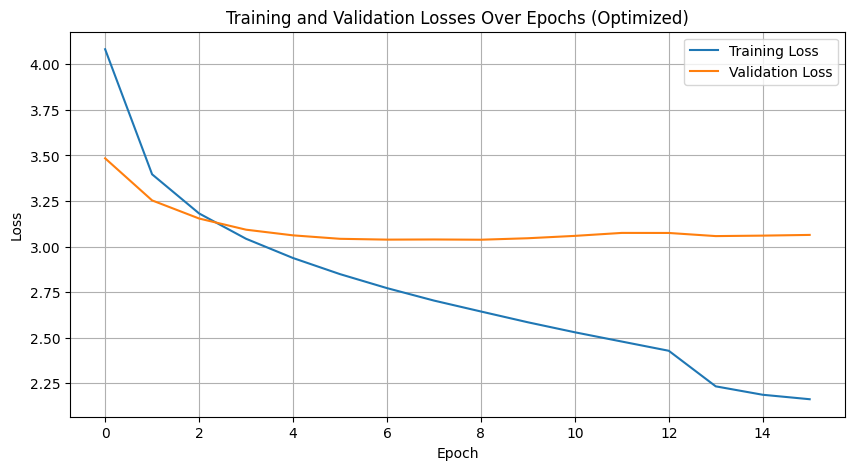

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.title('Training and Validation Losses Over Epochs (Optimized)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
final_model_save_path = os.path.join(base_path, "final_hybrid_caption_model_v2_optimized.pth")
torch.save(caption_model.state_dict(), final_model_save_path)

In [36]:
caption_model = HybridCaptioningModel(
    embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, vocab_size=VOCAB_SIZE,
    encoder_feature_dim=ENCODER_DIM, dropout_rate=DROPOUT_RATE
).to(DEVICE)

caption_model.load_state_dict(torch.load(final_model_save_path, map_location=DEVICE))
#caption_model.load_state_dict(torch.load(MODEL_SAVE_PATH_v2, map_location=DEVICE))

<All keys matched successfully>

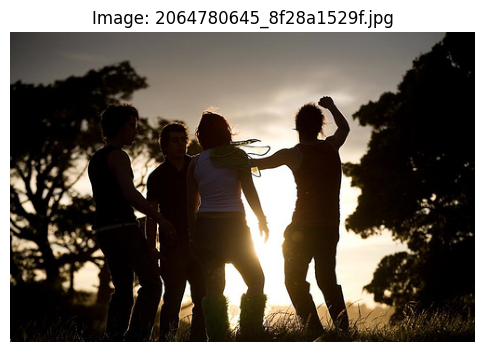

Image: 2064780645_8f28a1529f.jpg
  Reference Caption: a group of people standing in front of a setting sun
  Greedy Search:     a man and a woman are walking through a grassy field
  Beam Search (k=5): a group of people are riding horses on the beach
--------------------------------------------------


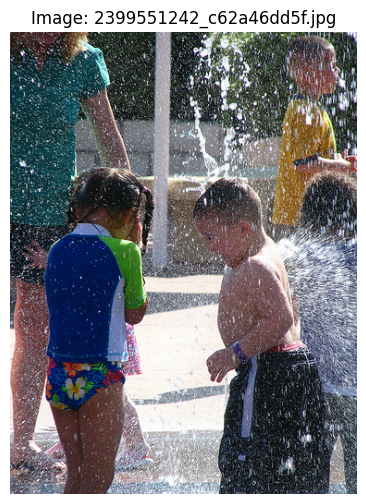

Image: 2399551242_c62a46dd5f.jpg
  Reference Caption: children in swimming suits playing in water
  Greedy Search:     a group of children play in the water
  Beam Search (k=5): a group of children play in the water
--------------------------------------------------


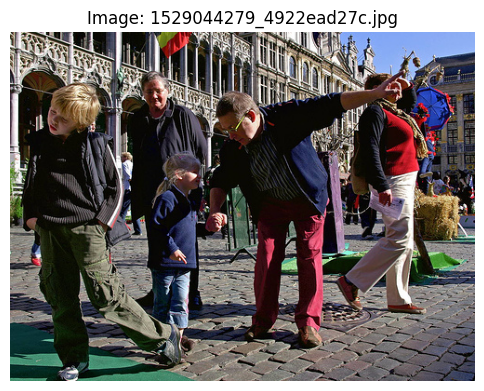

Image: 1529044279_4922ead27c.jpg
  Reference Caption: a crowded street in europe
  Greedy Search:     a group of people are standing in a circle on a busy street
  Beam Search (k=5): a group of people are standing in front of a large building
--------------------------------------------------


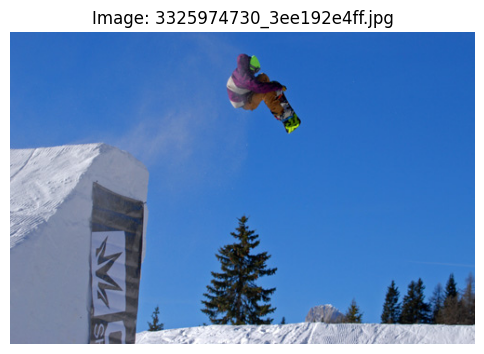

Image: 3325974730_3ee192e4ff.jpg
  Reference Caption: a snowboarder jumps high into the air off of a snowy ramp
  Greedy Search:     a man is snowboarding down a hill
  Beam Search (k=5): a man in a red jacket is snowboarding down a snowy hill
--------------------------------------------------


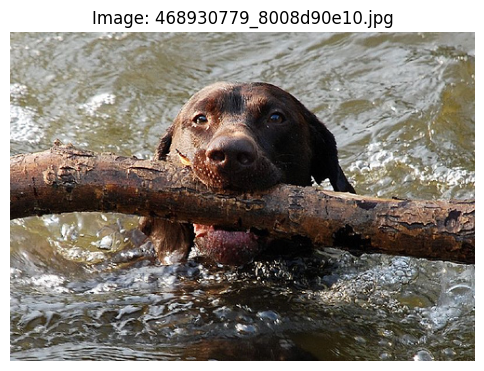

Image: 468930779_8008d90e10.jpg
  Reference Caption: a brown dog carrying a stick in its mouth
  Greedy Search:     a dog is running through the water
  Beam Search (k=5): a dog swims in the water
--------------------------------------------------


In [39]:
num_images_to_display = 5
idx_to_word = {idx: word for word, idx_str in vocab.items() for idx in [int(idx_str)]}
unique_test_image_files = list(test_dataset.data.keys())

selected_image_filenames = random.sample(unique_test_image_files, num_images_to_display)


for img_filename in selected_image_filenames:
    image_path = os.path.join(IMAGES_DIR, img_filename)
    pil_image = Image.open(image_path).convert("RGB")
    transformed_image = image_transform(pil_image)

    greedy_ids = caption_model.generate_caption_greedy(transformed_image, vocab, max_len=20, device=DEVICE)
    greedy_caption = ' '.join([idx_to_word.get(idx, '<unk>') for idx in greedy_ids if idx != vocab['<sos>'] and idx != vocab['<pad>']])
    if greedy_caption.endswith(" <eos>"): greedy_caption = greedy_caption[:-len(" <eos>")]

    beam_width = 5
    beam_ids = caption_model.generate_caption_beam_search(transformed_image, vocab, max_len=20, beam_width=beam_width, device=DEVICE)
    beam_caption = ' '.join([idx_to_word.get(idx, '<unk>') for idx in beam_ids if idx != vocab['<sos>'] and idx != vocab['<pad>']])
    if beam_caption.endswith(" <eos>"): beam_caption = beam_caption[:-len(" <eos>")]

    plt.figure(figsize=(6,6))
    plt.imshow(pil_image)
    plt.title(f"Image: {img_filename}")
    plt.axis('off')
    plt.show()

    print(f"Image: {img_filename}")
    reference_captions_ids = test_dataset.data[img_filename]
    if reference_captions_ids:
        ref_ids = reference_captions_ids[0]
        ref_caption_words = [idx_to_word.get(r_id, "<unk>") for r_id in ref_ids if r_id != vocab['<sos>'] and r_id != vocab['<pad>']]
        if ref_caption_words and ref_caption_words[-1] == "<eos>": ref_caption_words = ref_caption_words[:-1]
        print(f"  Reference Caption: {' '.join(ref_caption_words)}")

    print(f"  Greedy Search:     {greedy_caption}")
    print(f"  Beam Search (k={beam_width}): {beam_caption}")
    print("-" * 50)

In [32]:
with open(TEST_JSON, 'r') as f:
    test_data_json = json.load(f)
test_image_filenames = list(test_data_json.keys())

with open(VOCAB_FILE, 'r') as f:
    vocab_map = json.load(f)
idx_to_word_map = {int(idx_str): word for word, idx_str in vocab_map.items()}

greedy_hypotheses = []
beam_hypotheses = []
all_references = []

BEAM_WIDTH = 5
MAX_CAPTION_LEN = 20


for i, img_filename in enumerate(test_image_filenames):
    image_path = os.path.join(IMAGES_DIR, img_filename)
    try:
        pil_image = Image.open(image_path).convert("RGB")
        transformed_image = image_transform(pil_image)
    except FileNotFoundError:
        print(f"Image {img_filename} not found at {image_path}.")
        continue

    reference_ids_list = test_data_json[img_filename]
    current_image_references = [ids_to_clean_words(ref_ids, idx_to_word_map, vocab_map) for ref_ids in reference_ids_list]
    all_references.append(current_image_references)

    greedy_ids = caption_model.generate_caption_greedy(transformed_image, vocab_map, max_len=MAX_CAPTION_LEN, device=DEVICE)
    greedy_words = ids_to_clean_words(greedy_ids, idx_to_word_map, vocab_map)
    greedy_hypotheses.append(greedy_words)

    beam_ids = caption_model.generate_caption_beam_search(transformed_image, vocab_map, max_len=MAX_CAPTION_LEN, beam_width=BEAM_WIDTH, device=DEVICE)
    beam_words = ids_to_clean_words(beam_ids, idx_to_word_map, vocab_map)
    beam_hypotheses.append(beam_words)

    if (i + 1) % 50 == 0:
        print(f"  Processed {i+1}/{len(test_image_filenames)} images...")

chencherry = SmoothingFunction()

if greedy_hypotheses:
    bleu1_greedy = corpus_bleu(all_references, greedy_hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=chencherry.method1)
    bleu2_greedy = corpus_bleu(all_references, greedy_hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method1)
    bleu3_greedy = corpus_bleu(all_references, greedy_hypotheses, weights=(0.333, 0.333, 0.333, 0), smoothing_function=chencherry.method1)
    bleu4_greedy = corpus_bleu(all_references, greedy_hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)
    print("\n--- Greedy Search BLEU Scores ---")
    print(f"  BLEU-1: {bleu1_greedy:.4f}")
    print(f"  BLEU-2: {bleu2_greedy:.4f}")
    print(f"  BLEU-3: {bleu3_greedy:.4f}")
    print(f"  BLEU-4: {bleu4_greedy:.4f}")

if beam_hypotheses:
    bleu1_beam = corpus_bleu(all_references, beam_hypotheses, weights=(1.0, 0, 0, 0), smoothing_function=chencherry.method1)
    bleu2_beam = corpus_bleu(all_references, beam_hypotheses, weights=(0.5, 0.5, 0, 0), smoothing_function=chencherry.method1)
    bleu3_beam = corpus_bleu(all_references, beam_hypotheses, weights=(0.333, 0.333, 0.333, 0), smoothing_function=chencherry.method1)
    bleu4_beam = corpus_bleu(all_references, beam_hypotheses, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1)
    print(f"\n--- Beam Search (k={BEAM_WIDTH}) BLEU Scores ---")
    print(f"  BLEU-1: {bleu1_beam:.4f}")
    print(f"  BLEU-2: {bleu2_beam:.4f}")
    print(f"  BLEU-3: {bleu3_beam:.4f}")
    print(f"  BLEU-4: {bleu4_beam:.4f}")


  Processed 50/810 images...
  Processed 100/810 images...
  Processed 150/810 images...
  Processed 200/810 images...
  Processed 250/810 images...
  Processed 300/810 images...
  Processed 350/810 images...
  Processed 400/810 images...
  Processed 450/810 images...
  Processed 500/810 images...
  Processed 550/810 images...
  Processed 600/810 images...
  Processed 650/810 images...
  Processed 700/810 images...
  Processed 750/810 images...
  Processed 800/810 images...

--- Greedy Search BLEU Scores ---
  BLEU-1: 0.5302
  BLEU-2: 0.3493
  BLEU-3: 0.2242
  BLEU-4: 0.1452

--- Beam Search (k=5) BLEU Scores ---
  BLEU-1: 0.5520
  BLEU-2: 0.3644
  BLEU-3: 0.2358
  BLEU-4: 0.1533
